In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import combinations, islice
from scipy import stats
from collections import defaultdict, Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

from news_vec.corpus import Corpus
from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
class Actors:
    
    def __init__(self, root, skim=None):
        self.root = root
        self.skim = skim
        
    def __iter__(self):
        reader = islice(read_json_gz_lines(self.root), self.skim)
        yield from tqdm(reader)

In [17]:
actors = Actors('../data/clf-actors.json/')

In [18]:
next(iter(actors))

0it [00:00, ?it/s]


{'actor_id': 'id:twitter.com:2793391472',
 'article_id': 37255,
 'domain': 'apnews.com',
 'ts_bucket': 7}

In [19]:
ACTOR_DOMAIN_COUNTS = defaultdict(Counter)
ARTICLE_ACTORS = defaultdict(set)

for r in actors:
    ACTOR_DOMAIN_COUNTS[r['actor_id']][r['domain']] += 1
    ARTICLE_ACTORS[r['article_id']].add(r['actor_id'])

76224508it [07:41, 165279.92it/s]


In [20]:
len(ACTOR_DOMAIN_COUNTS)

8444480

In [21]:
ACTOR_DOMAIN_DISTS = {}

for aid, counts in tqdm(ACTOR_DOMAIN_COUNTS.items()):
    total = sum(counts.values())
    dist = dict([(d, count / total) for d, count in counts.items()])
    ACTOR_DOMAIN_DISTS[aid] = dist

100%|██████████| 8444480/8444480 [00:41<00:00, 204876.00it/s]


In [22]:
ACTOR_DOMAIN_DISTS['id:twitter.com:2793391472']

{'apnews.com': 0.49585406301824214,
 'npr.org': 0.03648424543946932,
 'cnn.com': 0.05472636815920398,
 'dailykos.com': 0.01658374792703151,
 'nytimes.com': 0.12106135986733002,
 'huffingtonpost.com': 0.03648424543946932,
 'washingtonpost.com': 0.1077943615257048,
 'foxnews.com': 0.004975124378109453,
 'thehill.com': 0.0812603648424544,
 'buzzfeed.com': 0.011608623548922056,
 'wsj.com': 0.014925373134328358,
 'bloomberg.com': 0.01824212271973466}

In [23]:
ARTICLE_ACTORS[3378]

{'id:twitter.com:1069174837',
 'id:twitter.com:124814437',
 'id:twitter.com:1905590958',
 'id:twitter.com:191162512',
 'id:twitter.com:22438091',
 'id:twitter.com:256184059',
 'id:twitter.com:28645214',
 'id:twitter.com:3080050650',
 'id:twitter.com:3090358105',
 'id:twitter.com:354537587',
 'id:twitter.com:55618046',
 'id:twitter.com:747144457741606912',
 'id:twitter.com:838526550660296704',
 'id:twitter.com:849723351715139584',
 'id:twitter.com:851305143933046785'}

In [24]:
def article_mean_actor_domain_pct(article_id, domain):
    actors = ARTICLE_ACTORS[article_id]
    pcts = [ACTOR_DOMAIN_DISTS[aid].get(domain, 0) for aid in actors]
    return np.mean(pcts)

In [26]:
article_mean_actor_domain_pct(3378, 'foxnews.com')

0.18167772698894957

In [31]:
corpus = Corpus('../data/clf-headlines.json/')

2018-12-29 17:00:41,442 | INFO : Reading headlines.
1225511it [01:25, 14306.53it/s]


In [32]:
def pred_ab(d1, d2):
    
    df = corpus.sample_ab(d1, d2)

    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )

    df_train, df_test = train_test_split(df)

    X_train = tv.fit_transform(df_train.clf_tokens)
    X_test = tv.transform(df_test.clf_tokens)

    clf = LogisticRegression(solver='lbfgs')
    fit = clf.fit(X_train, df_train.domain)

    df_test = df_test.copy()
    
    df_test['p_true'] = [
        p[0] if d==fit.classes_[0] else p[1]
        for p, d in zip(fit.predict_proba(X_test), df_test.domain)
    ]
    
    df_test['p_false'] = 1 - df_test.p_true
    
    df_test['b_domain'] = df_test.domain.apply(lambda d: d1 if d==d2 else d2)
    df_test['b_actor_pct'] = df_test.apply(lambda r: article_mean_actor_domain_pct(r.article_id, r.b_domain), 1)
    df_test['b_actor_pct_scaled'] = preprocessing.scale(df_test.b_actor_pct)
    
    return df_test

In [33]:
def pf_bpct_corr(pred_df, domain):
    df = pred_df[pred_df.domain==domain].copy()
    corr, p = stats.pearsonr(df.p_false, df.b_actor_pct)
    return corr, p, df

In [34]:
def plot_sl_audience(d1, d2):
    
    pred_df = pred_ab(d1, d2)
    corr, p, ddf = pf_bpct_corr(pred_df, d1)
    
    plt.figure(figsize=(10,5))
    
    print(corr, p)
    
    sns.jointplot(
        y='b_actor_pct',
        x='p_false',
        data=ddf,
        height=10,
        kind='reg',
        scatter_kws=dict(s=1),
    )
    
    plt.show()
    
    return pred_df

0.3922543470136538 1.17248274997577e-247


<Figure size 720x360 with 0 Axes>

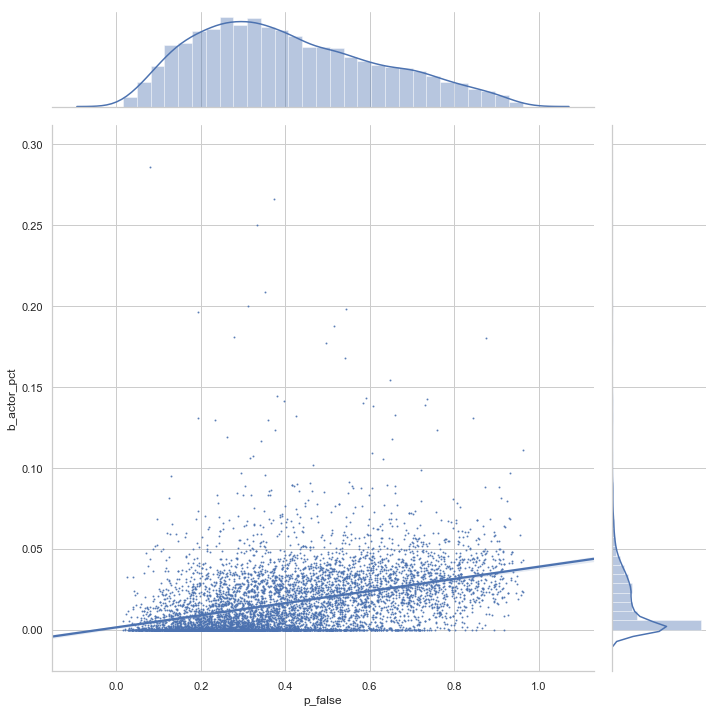

In [38]:
_ = plot_sl_audience('huffingtonpost.com', 'dailykos.com')

-0.012530354339441758 0.30476532694760566


<Figure size 720x360 with 0 Axes>

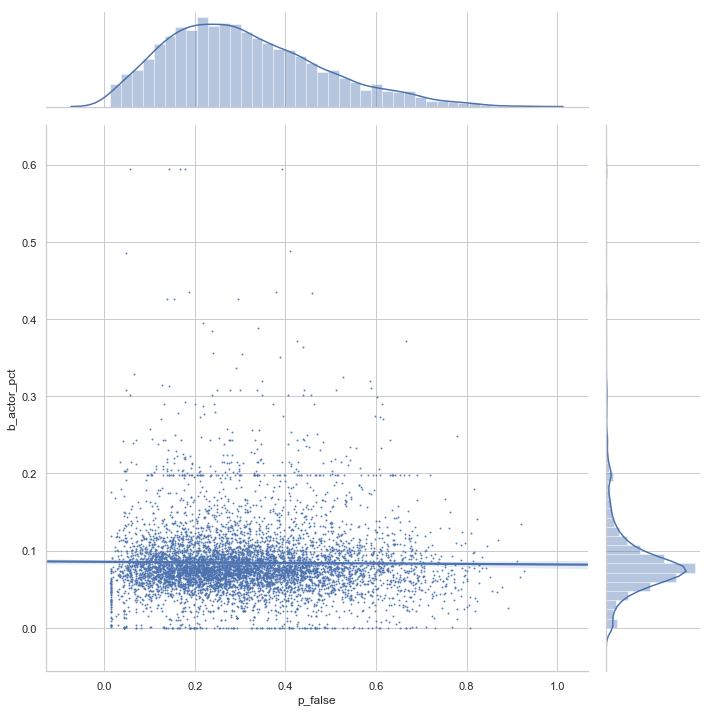

In [45]:
_ = plot_sl_audience('dailykos.com', 'huffingtonpost.com')

-0.04767386123852601 9.89062685328747e-05


<Figure size 720x360 with 0 Axes>

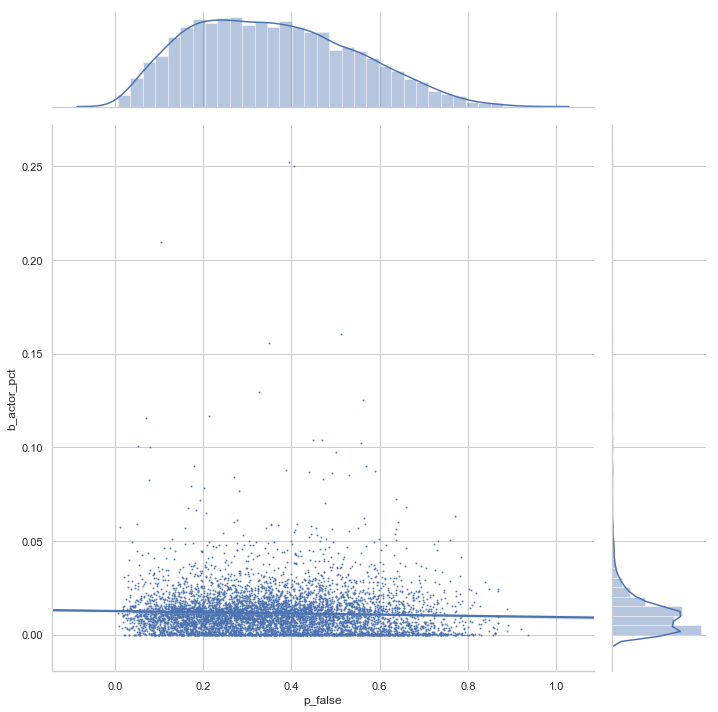

In [39]:
_ = plot_sl_audience('foxnews.com', 'apnews.com')

-0.001793636828996348 0.8830227187927775


<Figure size 720x360 with 0 Axes>

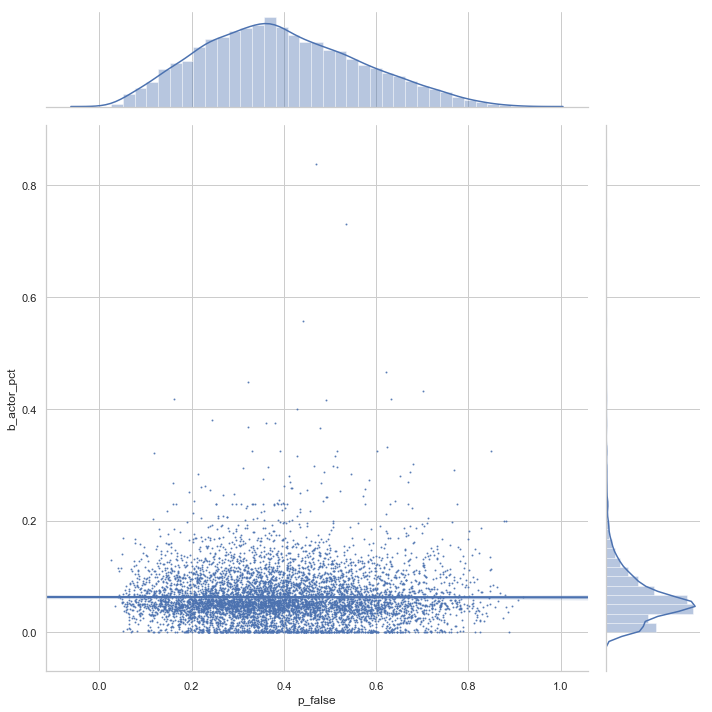

In [41]:
_ = plot_sl_audience('foxnews.com', 'cnn.com')

0.10543612849581153 6.743569464507389e-18


<Figure size 720x360 with 0 Axes>

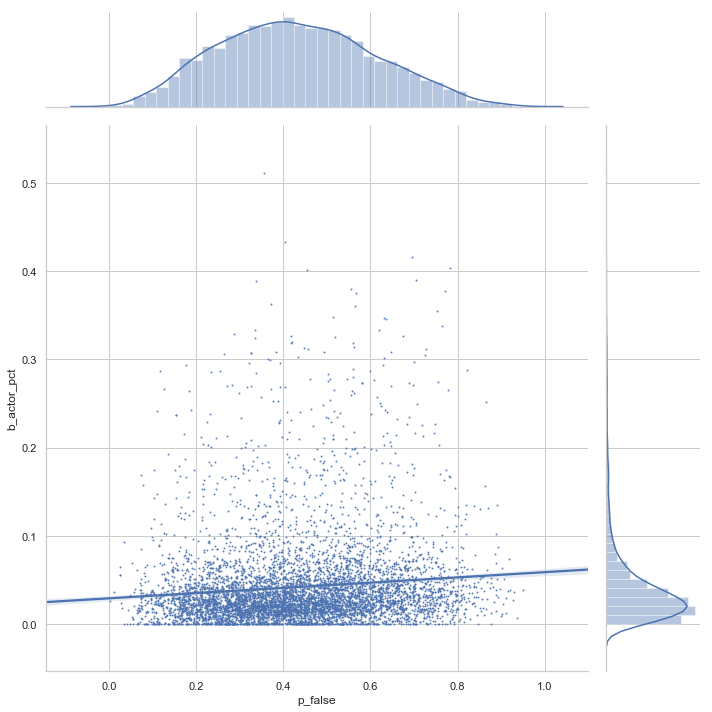

In [42]:
_ = plot_sl_audience('cnn.com', 'foxnews.com')

0.09694845719980635 1.4344286100138802e-15


<Figure size 720x360 with 0 Axes>

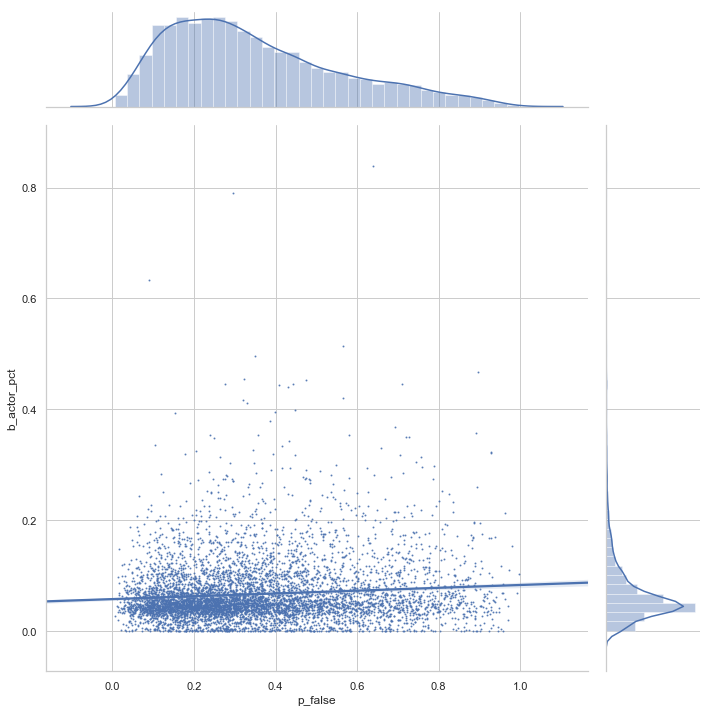

In [43]:
_ = plot_sl_audience('foxnews.com', 'nytimes.com')

0.08716613793212215 1.0513226643353002e-12


<Figure size 720x360 with 0 Axes>

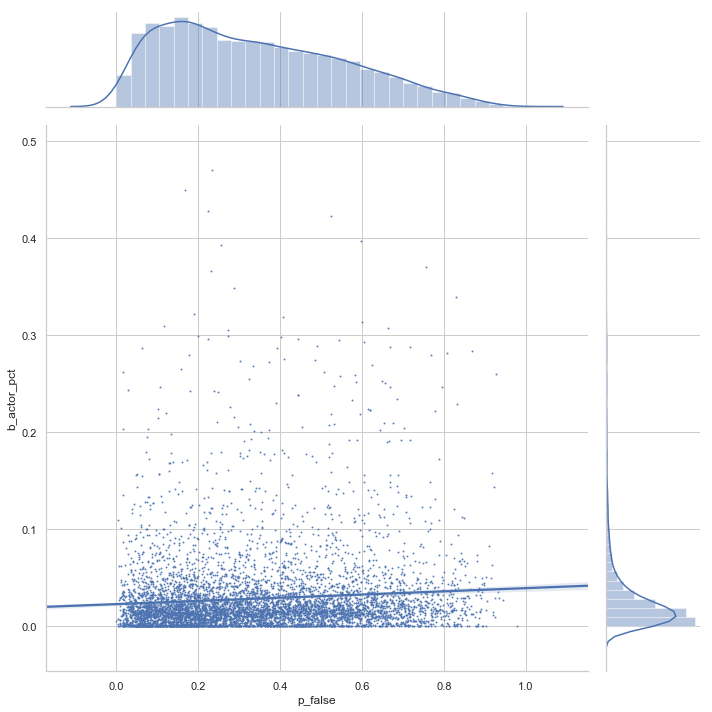

In [44]:
_ = plot_sl_audience('nytimes.com', 'foxnews.com')

0.07502042985230442 8.207704064388593e-10


<Figure size 720x360 with 0 Axes>

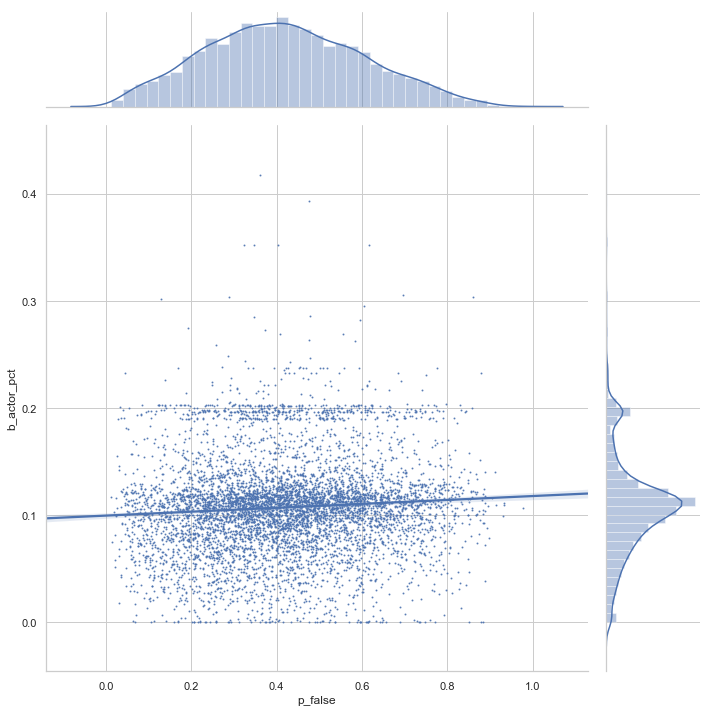

In [46]:
_ = plot_sl_audience('breitbart.com', 'dailycaller.com')

0.014621550148726072 0.229564820732217


<Figure size 720x360 with 0 Axes>

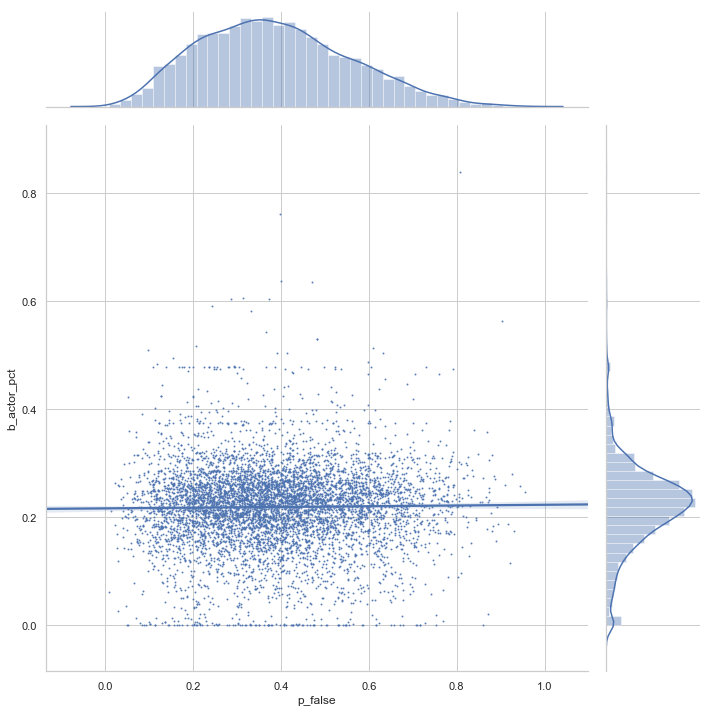

In [47]:
_ = plot_sl_audience('dailycaller.com', 'breitbart.com')

0.539449604538018 0.0


<Figure size 720x360 with 0 Axes>

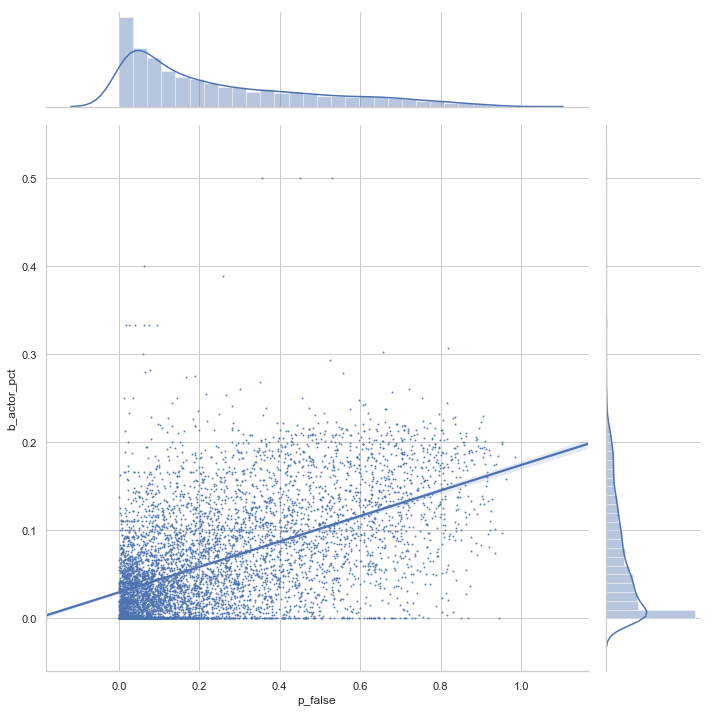

In [48]:
_ = plot_sl_audience('buzzfeed.com', 'washingtonpost.com')

0.37616922841574013 9.402848887908773e-225


<Figure size 720x360 with 0 Axes>

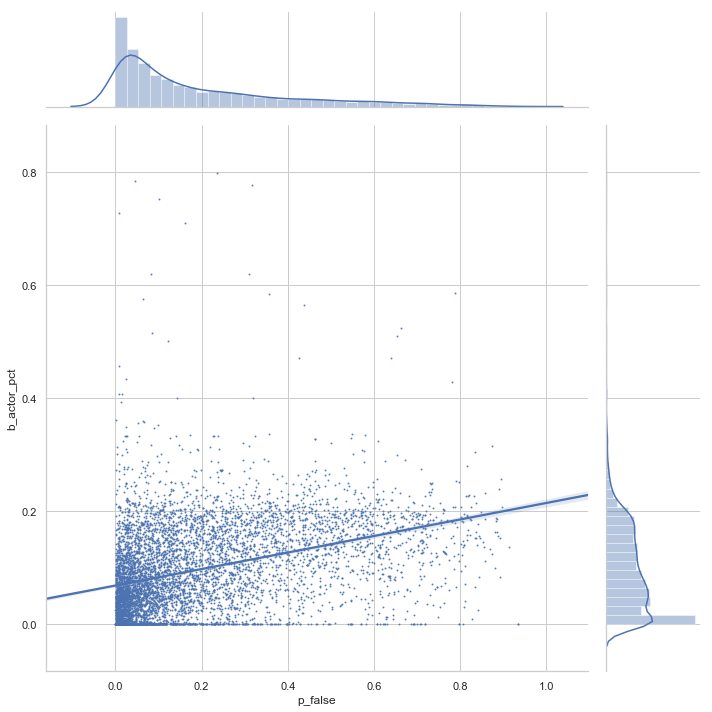

In [52]:
_ = plot_sl_audience('buzzfeed.com', 'nytimes.com')

-0.11508135719533194 2.382784641813304e-21


<Figure size 720x360 with 0 Axes>

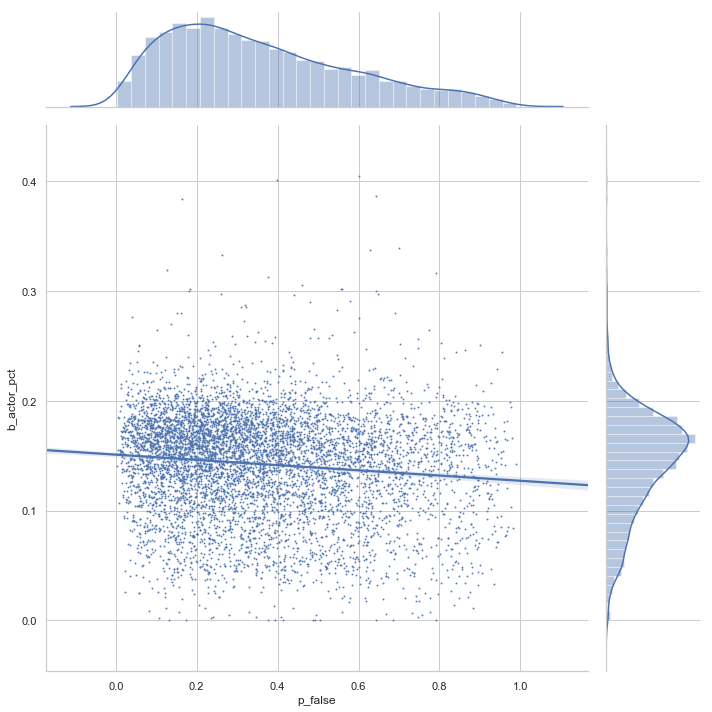

In [68]:
_ = plot_sl_audience('thehill.com', 'washingtonpost.com')

0.22074846993281919 2.255962198265761e-74


<Figure size 720x360 with 0 Axes>

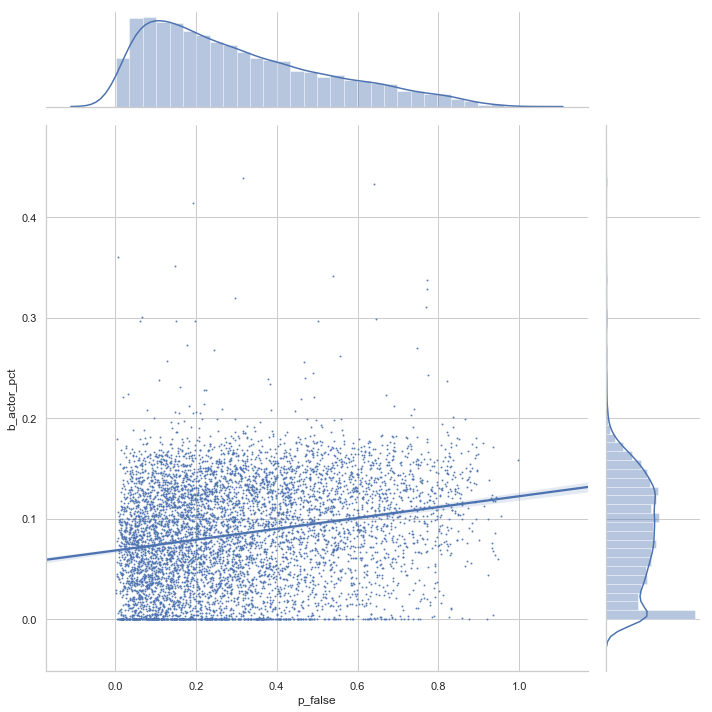

In [74]:
_ = plot_sl_audience('washingtonpost.com', 'thehill.com')

-0.1039038065511233 1.881383752043153e-17


<Figure size 720x360 with 0 Axes>

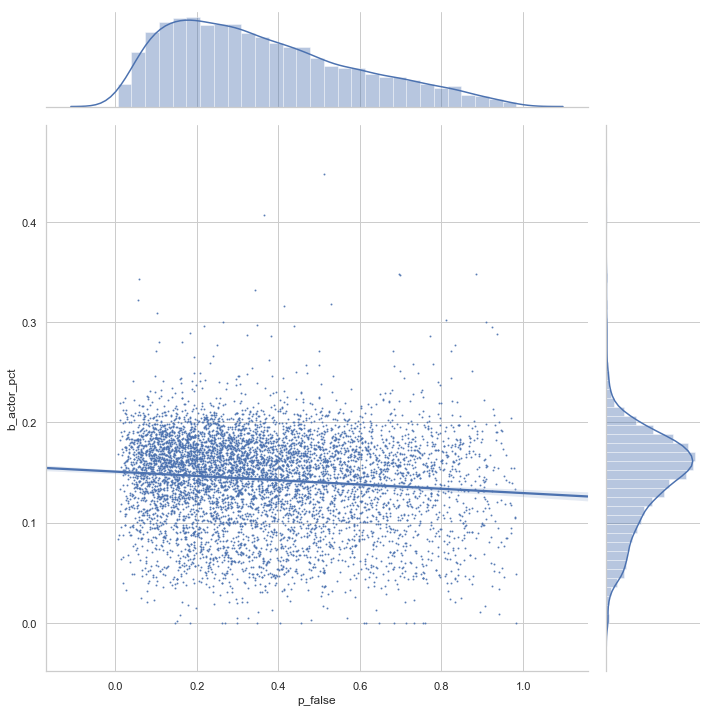

In [75]:
_ = plot_sl_audience('thehill.com', 'washingtonpost.com')

In [53]:
domains = corpus.df.domain.unique()

In [54]:
pairs = list(combinations(domains, 2))

In [55]:
rows = []
for d1, d2 in tqdm(pairs):
    pred_df = pred_ab(d1, d2)
    corr1, p1, _ = pf_bpct_corr(pred_df, d1)
    corr2, p2, _ = pf_bpct_corr(pred_df, d2)
    rows.append((d1, d2, corr1, p1))
    rows.append((d2, d1, corr2, p2))

  0%|          | 0/120 [00:00<?, ?it/s]/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
 59%|█████▉    | 71/120 [26:48<17:15, 21.14s/it]/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
 80%|████████  | 96/120 [35:34<08:24, 21.02s/it]/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
100%|██████████| 120/120 [43:02<00:00, 15.19s/it]


In [56]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p'))

In [57]:
df['label'] = df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

In [73]:
df[df.d2=='dailycaller.com'].sort_values('corr', ascending=False)

,d1,d2,corr,p,label
54,wsj.com,dailycaller.com,0.222645,1.555304e-75,wsj.com -> dailycaller.com
194,foxnews.com,dailycaller.com,0.153958,7.180701e-37,foxnews.com -> dailycaller.com
104,buzzfeed.com,dailycaller.com,0.143513,2.977193e-32,buzzfeed.com -> dailycaller.com
239,rt.com,dailycaller.com,0.136561,2.059536e-29,rt.com -> dailycaller.com
26,bloomberg.com,dailycaller.com,0.134686,1.022097e-28,bloomberg.com -> dailycaller.com
80,cnn.com,dailycaller.com,0.133370,3.142169e-28,cnn.com -> dailycaller.com
216,washingtonpost.com,dailycaller.com,0.126464,2.544223e-25,washingtonpost.com -> dailycaller.com
146,huffingtonpost.com,dailycaller.com,0.120244,6.863525e-23,huffingtonpost.com -> dailycaller.com
164,nytimes.com,dailycaller.com,0.103091,2.322844e-17,nytimes.com -> dailycaller.com
234,npr.org,dailycaller.com,0.098365,4.593157e-16,npr.org -> dailycaller.com


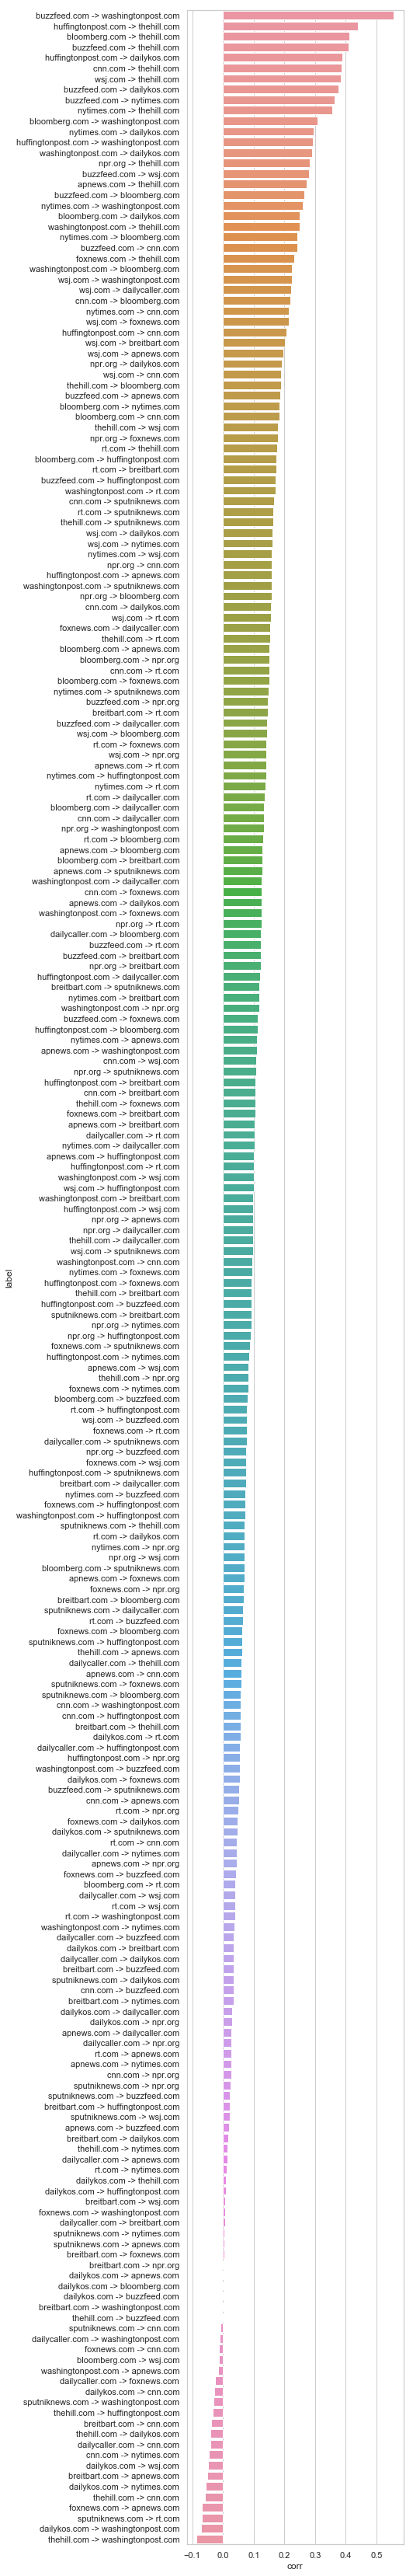

In [58]:
plt.figure(figsize=(5,60))
sns.barplot(x='corr', y='label', data=df.sort_values('corr', ascending=False))